# Collecting data from a Liander Smart Energy Meter 
(In Dutch: Uitlezen van de slimme meter van Alliander/Liander)

Author: Marcel van den Bosch (email: marcel@marcel.im)

Date:06-Jun-2018

In the example we establish a serial rs-232 connection to the smart meter device, using the P1 port.
The metering data is transmitted as a "telegram" packet. This telegram contains data, such the meter readings and
meter ID code.

![title](img/smartmeter_p1.png)

To do:
- Expose functionality as a REST API
- Write a service that can feed an InfluxDB timeseries database and develop some Grafana dashboards.


In [1]:
import sys
import serial
import re

In [2]:
ser = serial.Serial()
ser.baudrate = 115200
ser.bytesize=serial.EIGHTBITS
ser.parity=serial.PARITY_NONE
ser.stopbits=serial.STOPBITS_ONE
ser.xonxoff=0
ser.rtscts=0
ser.timeout=20
ser.port="/dev/ttyUSB0"

In [3]:
#Open COM port
try:
    ser.open()
except:
    print ("Cannot open device:"  % ser.name)

In [4]:
def getSmartMeterData(inSerial,printOutput = False,verbose = False):
    buffer=[]
    telegram_start = False;
    # Empty dict
    data = {}
    
    while True:
        p1_line_in=''
        
        try:
            p1_raw = ser.readline()
        except:
            print ("Error reading from port." % ser.name )
            return(False)
        
        p1_str=str(p1_raw, "utf-8")
        p1_line_in=p1_str.strip()
        
        if telegram_start == False:
            if len(p1_line_in) >0:
                if p1_line_in[0] == "/":
                    buffer.append(p1_line_in)
                    if verbose == True: print ("Line:",p1_line_in)
                    telegram_start = True
        else:
            buffer.append(p1_line_in)
            if verbose == True: print ("Line:",p1_line_in)
            
            if len(p1_line_in) >0:
                if p1_line_in[0] == "!":
                    telegram_start = False
                    if len(buffer) == 26:
                        break
                    else:
                        print("Corrupt packet, expected length %i got %i -> Retrying!" % (26,len(buffer)))
                        buffer = []

    for line in buffer:
        if re.search("1-0:1.8.1", line):
            data['READING_POWER_IN_LOW_TARIFF'] = float(re.search(r'\(([\d\.]*)\*', line).group(1));
            if printOutput == True: print("Meter Reading electricity delivered to client (low tariff) in 0,001 kWh:\t\t%.3f kWh" %
                                     float(re.search(r'\(([\d\.]*)\*', line).group(1)))
        elif re.search("1-0:1.8.2", line):
            data['READING_POWER_IN_NORM_TARIFF'] = float(re.search(r'\(([\d\.]*)\*', line).group(1));
            if printOutput == True: print("Meter Reading electricity delivered to client (normal tariff) in 0,001 kWh:\t\t%.3f kWh" %
                                      float(re.search(r'\(([\d\.]*)\*', line).group(1)))
        elif re.search("1-0:2.8.1", line):
            data['READING_POWER_OUT_LOW_TARIFF'] = float(re.search(r'\(([\d\.]*)\*', line).group(1))
            if printOutput == True: print("Meter Reading electricity delivered by client (low tariff) in 0,001 kWh:\t\t%.3f kWh" % 
                                      float(re.search(r'\(([\d\.]*)\*', line).group(1)))
        elif re.search("1-0:2.8.2", line):
            data['READING_POWER_OUT_NORM_TARIFF'] = float(re.search(r'\(([\d\.]*)\*', line).group(1))
            if printOutput == True: print("Meter Reading electricity delivered by client (normal tariff) in 0,001 kWh:\t\t%.3f kWh" %
                                      float(re.search(r'\(([\d\.]*)\*', line).group(1)))
        elif re.search("1-0:1.7.0", line):
            data['ACTUAL_POWER_IN'] = float(re.search(r'\(([\d\.]*)\*', line).group(1))
            if printOutput == True: print("Actual electricity power delivered (+P) in 1 Watt resolution:\t\t\t\t%.3f kW" % 
                                      float(re.search(r'\(([\d\.]*)\*', line).group(1)))        
        elif re.search("1-0:2.7.0", line):
            data['ACTUAL_POWER_OUT'] = float(re.search(r'\(([\d\.]*)\*', line).group(1))
            if printOutput == True: print("Actual electricity power received (-P) in 1 Watt resolution:\t\t\t\t%.3f kW" %
                                      float(re.search(r'\(([\d\.]*)\*', line).group(1)))        
        # Gasmeter: 0-1:24.3.0
        elif re.search("0-1:24.2.1", line):
            data['READING_GAS_IN'] = float(re.search(r'\(([\d\.]*)\*', line).group(1))
            if printOutput == True: print("Gas Data - Gas delivered to client in m3:\t\t\t\t\t\t%.3f m3" %
                                     float(re.search(r'\(([\d\.]*)\*', line).group(1)))                
       # else:
               # pass
    buffer = []
    return(data)

In [5]:
getSmartMeterData(ser,printOutput = True, verbose = False)

Meter Reading electricity delivered to client (low tariff) in 0,001 kWh:		10.060 kWh
Meter Reading electricity delivered to client (normal tariff) in 0,001 kWh:		14.043 kWh
Meter Reading electricity delivered by client (low tariff) in 0,001 kWh:		0.000 kWh
Meter Reading electricity delivered by client (normal tariff) in 0,001 kWh:		0.000 kWh
Actual electricity power delivered (+P) in 1 Watt resolution:				0.456 kW
Actual electricity power received (-P) in 1 Watt resolution:				0.000 kW
Gas Data - Gas delivered to client in m3:						2.373 m3


{'ACTUAL_POWER_IN': 0.456,
 'ACTUAL_POWER_OUT': 0.0,
 'READING_GAS_IN': 2.373,
 'READING_POWER_IN_LOW_TARIFF': 10.06,
 'READING_POWER_IN_NORM_TARIFF': 14.043,
 'READING_POWER_OUT_LOW_TARIFF': 0.0,
 'READING_POWER_OUT_NORM_TARIFF': 0.0}

## Measure actual power consumption over a brief moment in time

In [6]:
import time
import datetime
import numpy as np
import pandas as pd

In [7]:
no_iter = 10 * (60/15) # 10 minutes with 15 seconds between each iteration

In [8]:
i = 0;
ts = list()
data = []

while i < no_iter:
    data = getSmartMeterData(ser)
    ts.append([datetime.datetime.now(),data['ACTUAL_POWER_IN']])
    time.sleep(15)
    i = i+1
    pass

Corrupt packet, expected length 26 got 4 -> Retrying!
Corrupt packet, expected length 26 got 33 -> Retrying!
Corrupt packet, expected length 26 got 4 -> Retrying!
Corrupt packet, expected length 26 got 33 -> Retrying!
Corrupt packet, expected length 26 got 6 -> Retrying!


In [9]:
df = pd.DataFrame.from_dict(ts)
df.columns = ['datetime', 'value']
df.set_index('datetime')
df.head(5)

,datetime,value
0,2018-06-06 19:57:05.393820,0.456
1,2018-06-06 19:57:20.414155,0.456
2,2018-06-06 19:57:35.421732,0.456
3,2018-06-06 19:57:50.443943,0.456
4,2018-06-06 19:58:05.466717,0.456


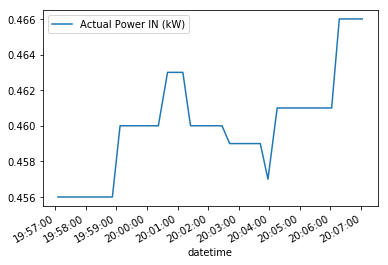

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()
ax.xaxis_date(tz=None)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

df.plot(x='datetime',y='value',label='Actual Power IN (kW)',ax=ax)

## The verbose version, showing the P1 data

In [11]:
getSmartMeterData(ser,printOutput = True, verbose = True)

Line: /XMX5LGBBLA4415507877
Line: 
Line: 1-3:0.2.8(50)
Line: 0-0:1.0.0(180606200602S)
Line: 0-0:96.1.1(4530303435303034323030363837303138)
Line: 1-0:1.8.1(000010.060*kWh)
Line: 1-0:1.8.2(000014.113*kWh)
Line: 1-0:2.8.1(000000.000*kWh)
Line: 1-0:2.8.2(000000.000*kWh)
Line: 0-0:96.14.0(0002)
Line: 1-0:1.7.0(00.466*kW)
Line: 1-0:2.7.0(00.000*kW)
Line: 0-0:96.7.21(00002)
Line: 0-0:96.7.9(00000)
Line: 1-0:99.97.0(0)(0-0:96.7.19)
Line: 1-0:32.32.0(00000)
Line: 1-0:32.36.0(00000)
Line: 0-0:96.13.0()
Line: 1-0:32.7.0(231.0*V)
Line: 1-0:31.7.0(002*A)
Line: 1-0:21.7.0(00.466*kW)
Line: 1-0:22.7.0(00.000*kW)
Line: 0-1:24.1.0(003)
Line: 0-1:96.1.0(4730303332353635353532323234393138)
Line: 0-1:24.2.1(180606200509S)(00002.384*m3)
Line: !8E3F
Meter Reading electricity delivered to client (low tariff) in 0,001 kWh:		10.060 kWh
Meter Reading electricity delivered to client (normal tariff) in 0,001 kWh:		14.113 kWh
Meter Reading electricity delivered by client (low tariff) in 0,001 kWh:		0.000 kWh
Meter 

{'ACTUAL_POWER_IN': 0.466,
 'ACTUAL_POWER_OUT': 0.0,
 'READING_GAS_IN': 2.384,
 'READING_POWER_IN_LOW_TARIFF': 10.06,
 'READING_POWER_IN_NORM_TARIFF': 14.113,
 'READING_POWER_OUT_LOW_TARIFF': 0.0,
 'READING_POWER_OUT_NORM_TARIFF': 0.0}

## Closing the serial port connection

In [12]:
#Close port and show status
try:
    ser.close()
except:
    print ("Fout: %s." % ser.name )